<a href="https://colab.research.google.com/github/vjardimb/style-transfer/blob/main/content_representation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Content Representation

The goal of this notebook is to implement the content represetation technique using the feature maps of the VGG16 for later use in the style transfer algortihm.

In [ ]:
import tensorflow as tf
from IPython.display import display, Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import imageio

In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Hyperparams

In [ ]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
CONTENT_LAYERS =  [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]
epochs = 1000
learning_rate=0.001

# Set random seeds

In [ ]:
np.random.seed(0)
tf.random.set_seed(0)

# Load Content Image


In [ ]:
# set img folder
content_img_folder = f'drive/MyDrive/ML Projects/style-transfer/content_img'
style_img_folder = f'drive/MyDrive/style-transfer/style_img'

# set content img
content_img_name = 'labrador.jpg'

# content path
content_img_path = os.path.join(content_img_folder, content_img_name)

# progress path
progress_path = 'drive/MyDrive/ML Projects/style-transfer/content_repr'

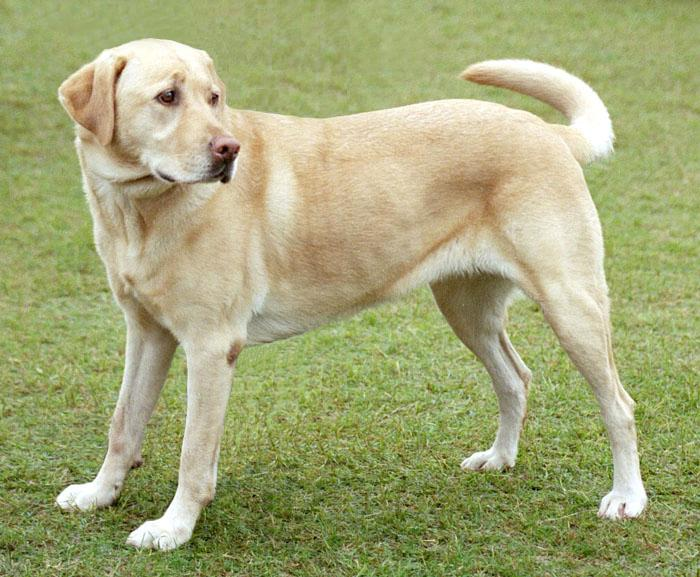

In [ ]:
display(Image(content_img_path))

In [ ]:
img = tf.io.read_file(content_img_path)
img = tf.image.decode_image(img, channels=3, dtype=tf.float32)
img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
img = tf.expand_dims(img, 0)

print("Image tensor shape: ", img.shape)

Image tensor shape:  (1, 224, 224, 3)


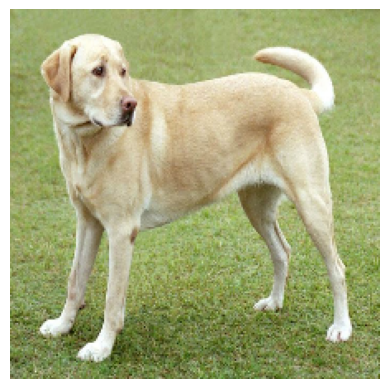

In [ ]:
plt.imshow(img.numpy()[0])
plt.axis('off')
plt.show()

# Load Model

In [ ]:
vgg_model = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(img.shape[1:]),
)

vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# build submodels
models = []

for layer in CONTENT_LAYERS:
  layer_output = vgg_model.get_layer(layer).output
  submodel = tf.keras.Model(inputs=vgg_model.input, outputs=layer_output)
  models.append(submodel)

# Define Optimization Functions


In [ ]:
def preprocess_model_input(input):
  return tf.keras.applications.vgg19.preprocess_input(input*255)

In [ ]:
@tf.function
def get_content_loss(model, content_img, generated_img):
  content_img = preprocess_model_input(content_img)
  generated_img = preprocess_model_input(generated_img)

  content_output = model(content_img)
  generated_output = model(generated_img)

  mse = tf.keras.losses.MeanSquaredError()

  return mse(content_output, generated_output)


In [ ]:
# test loss calcuation
noise = tf.random.normal([1, IMG_HEIGHT, IMG_WIDTH, 3], 0.5, 0.1)

get_content_loss(models[0], img, noise)

<tf.Tensor: shape=(), dtype=float32, numpy=1454.102>

In [ ]:
def update_gen_img(model, content_img, generated_img, opt):
  opt.minimize(
      lambda: get_content_loss(model, content_img, generated_img),
      var_list=[generated_img]
  )

  generated_img.assign(
      tf.clip_by_value(generated_img, clip_value_min=0, clip_value_max=1)
  )

# Util Functions

In [ ]:
def show_img(img_numpy, title=''):
  plt.imshow(img_numpy()[0])
  plt.axis('off')
  plt.title(title)
  plt.show()

In [ ]:
def save_progress_gif(img_list, id, folder_path):
  # Convert each image to uint8 format if needed
  images = [np.uint8(image*255) for image in img_list]

  # Save the images as a GIF
  file_name = f'{id}_content_progress.gif'
  file_path = os.path.join(folder_path, file_name)

  imageio.mimsave(file_path, images, duration=0.6)

In [ ]:
def show_progress(img_list, title=''):
  indices = np.linspace(0, len(img_list) - 1, 4, dtype=int)
  iterations = np.linspace(0, epochs - 1, 4, dtype=int)

  images_to_plot = [img_list[i] for i in indices]

  # Create a 1x4 grid of subplots
  fig, axes = plt.subplots(1, 4, figsize=(15, 5))  # Adjust figsize as needed

  # Plot each image in a subplot
  for idx, iter, ax in zip(indices, iterations, axes):
      ax.imshow(img_list[idx])
      ax.axis('off')  # Turn off axis labels
      ax.title.set_text(f'{iter}th iteration')

  fig.suptitle(title)

  plt.show()

# Iterate

In [ ]:
progress = {layer: [] for layer in CONTENT_LAYERS}

In [ ]:
opt = tf.keras.optimizers.legacy.Adam(
    learning_rate=learning_rate
)

for i, model in enumerate(models):
  print(f"\n\nbeginning model {i}\n\n")
  gen_img = tf.Variable(
      tf.random.normal([1, IMG_HEIGHT, IMG_WIDTH, 3], 0.5, 0.1)
  )

  for step in tqdm(range(epochs)):
    update_gen_img(model, img, gen_img, opt)

    if not step % 50:
      progress[CONTENT_LAYERS[i]].append(gen_img.numpy()[0])

  save_progress_gif(progress[CONTENT_LAYERS[i]], CONTENT_LAYERS[i], progress_path)



beginning model 0




100%|██████████| 1000/1000 [00:05<00:00, 174.83it/s]




beginning model 1




100%|██████████| 1000/1000 [00:10<00:00, 95.39it/s]




beginning model 2




100%|██████████| 1000/1000 [00:16<00:00, 60.69it/s]




beginning model 3




100%|██████████| 1000/1000 [00:27<00:00, 36.21it/s]




beginning model 4




100%|██████████| 1000/1000 [00:47<00:00, 21.22it/s]


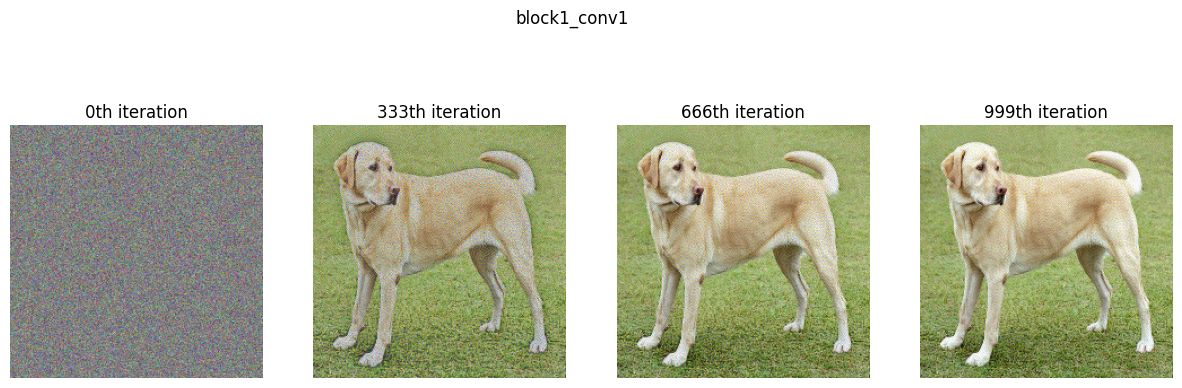

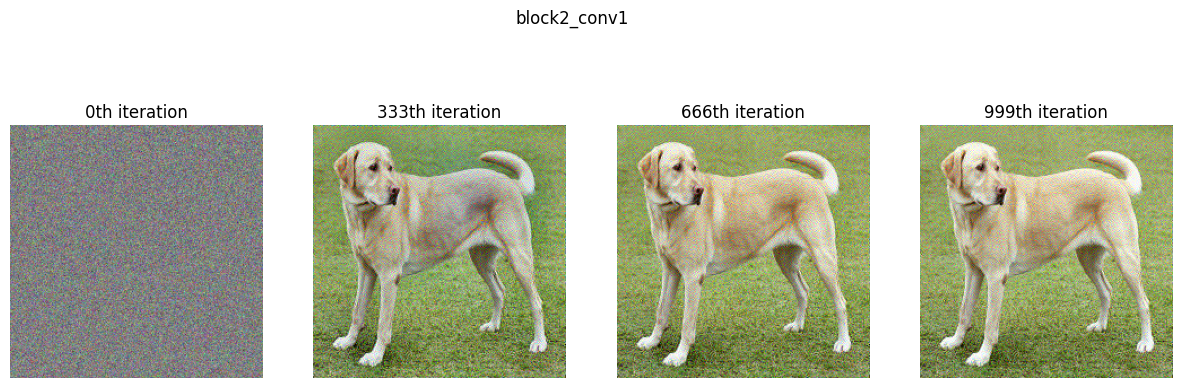

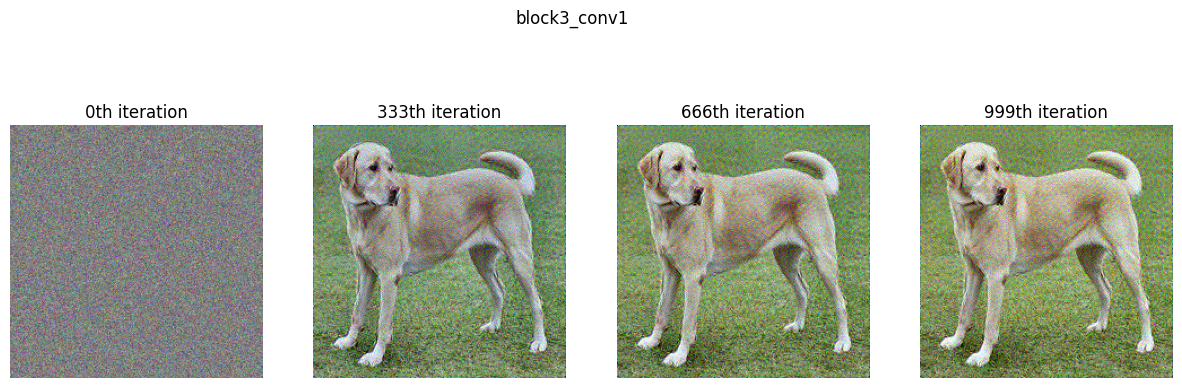

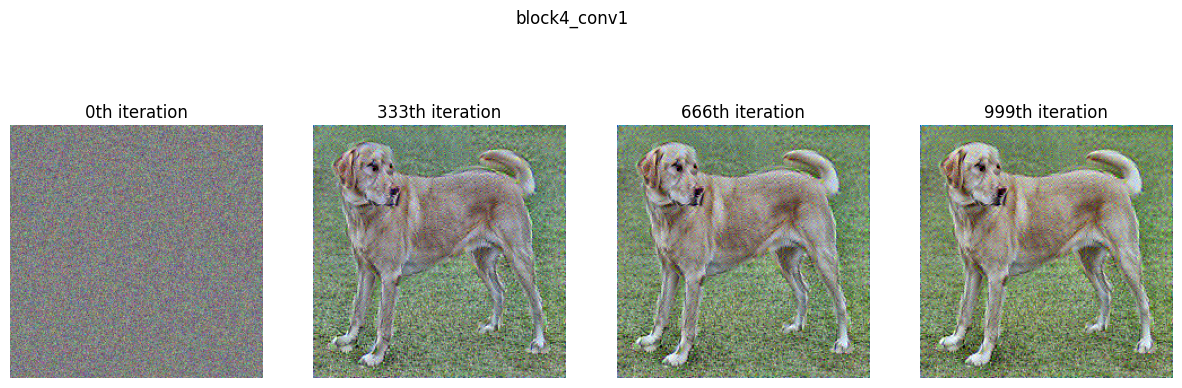

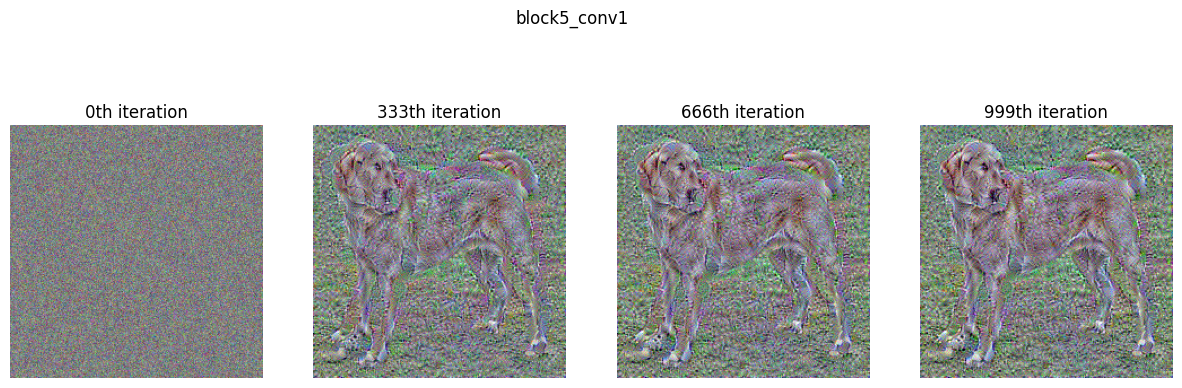

In [ ]:
for layer in CONTENT_LAYERS:
  show_progress(progress[layer], layer)